## LangGraph Fundamentals - Flow Engineering and Finite State Machine

What is LangGraph?
LangGraph is a low-level orchestration framework for building stateful, 
multi-agent applications. Think of it as a way to create workflows where 
each step (node) processes data and passes it to the next step.

Key Concepts:
1. State: Shared memory that all nodes can read from and write to
2. Nodes: Functions that do specific tasks (like process data)
3. Edges: Connections between nodes that define the flow

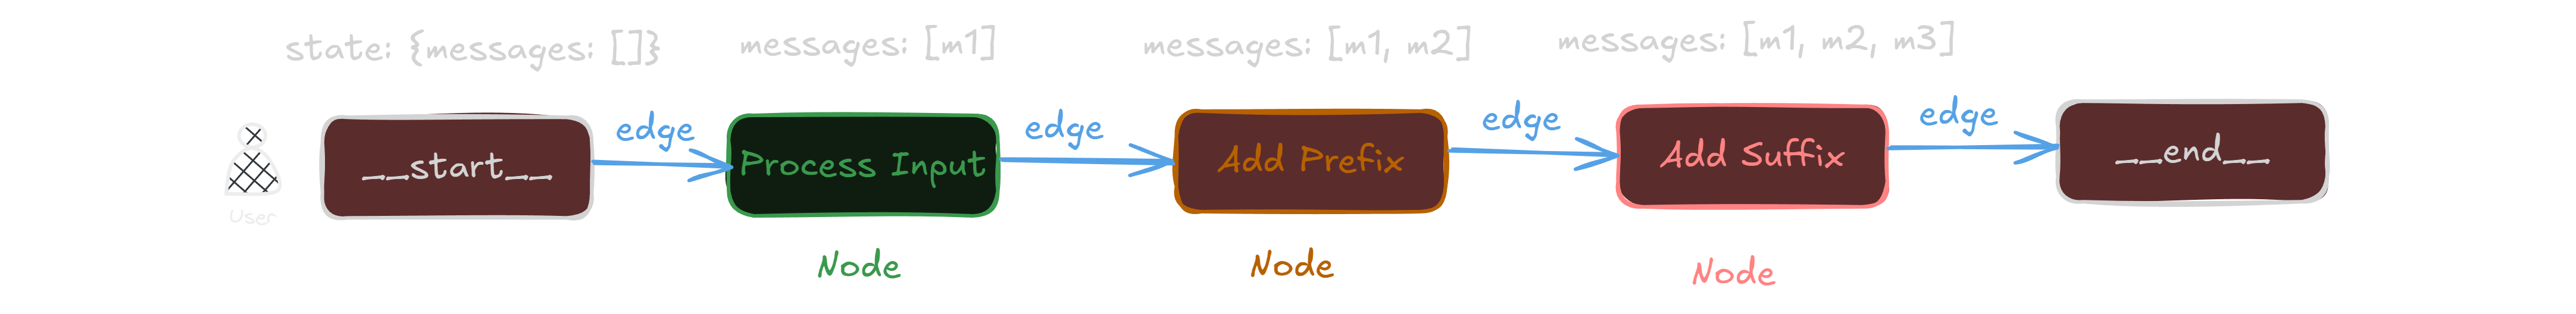

In [2]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END


In [4]:
# Step 1: Define the State
# State is like a shared notebook that all nodes can read and write to
class SimpleState(TypedDict):
    """
    Our state has two fields:
    - input_text: The original text from the user
    - output_text: The processed result
    """
    input_text: str
    output_text: str


In [5]:
state = SimpleState(
    input_text="Hello, LangGraph!",
    output_text=""
)

state

{'input_text': 'Hello, LangGraph!', 'output_text': ''}

In [6]:
# Step 2: Define Node Functions
# Nodes are just Python functions that take state and return updates
def process_input(state: SimpleState) -> dict:
    """
    First node: Takes the input text and converts it to uppercase.
    
    Args:
        state: Current state of the graph
    
    Returns:
        Dictionary with updates to the state
    """
    text = state["input_text"]
    processed = text.upper()
    
    print(f"Node 1 - Processing: '{text}' -> '{processed}'")
    
    # Return a dictionary to update the state
    return {"output_text": processed}


In [7]:
process_input(state)

Node 1 - Processing: 'Hello, LangGraph!' -> 'HELLO, LANGGRAPH!'


{'output_text': 'HELLO, LANGGRAPH!'}

In [8]:
def add_prefix(state: SimpleState) -> dict:
    """
    Second node: Adds a prefix to the processed text.
    
    Args:
        state: Current state of the graph
    
    Returns:
        Dictionary with updates to the state
    """
    current_text = state["output_text"]
    prefixed = f"PROCESSED: {current_text}"
    
    print(f"Node 2 - Adding prefix: '{current_text}' -> '{prefixed}'")
    
    return {"output_text": prefixed}



In [10]:
add_prefix(process_input(state))

Node 1 - Processing: 'Hello, LangGraph!' -> 'HELLO, LANGGRAPH!'
Node 2 - Adding prefix: 'HELLO, LANGGRAPH!' -> 'PROCESSED: HELLO, LANGGRAPH!'


{'output_text': 'PROCESSED: HELLO, LANGGRAPH!'}

In [20]:
def add_suffix(state: SimpleState) -> dict:
    """
    Third node: Adds a suffix to mark completion.
    
    Args:
        state: Current state of the graph
    
    Returns:
        Dictionary with updates to the state
    """
    current_text = state["output_text"]
    final = f"{current_text} [COMPLETE]"
    
    print(f"Node 3 - Adding suffix: '{current_text}' -> '{final}'")
    
    # return {"output_text": final}
    return {"output_text": final, "finalized": True, "input_text": "Goodbye!"}


In [21]:
add_suffix(add_prefix(process_input(state)))

Node 1 - Processing: 'Hello, LangGraph!' -> 'HELLO, LANGGRAPH!'
Node 2 - Adding prefix: 'HELLO, LANGGRAPH!' -> 'PROCESSED: HELLO, LANGGRAPH!'
Node 3 - Adding suffix: 'PROCESSED: HELLO, LANGGRAPH!' -> 'PROCESSED: HELLO, LANGGRAPH! [COMPLETE]'


{'output_text': 'PROCESSED: HELLO, LANGGRAPH! [COMPLETE]',
 'finalized': True,
 'input_text': 'Goodbye!'}

In [22]:
# Step 3: Build the Graph
def create_simple_graph():
    """
    Creates and compiles a simple linear graph.
    
    Flow: START -> process_input -> add_prefix -> add_suffix -> END
    """
    
    # Create the graph builder
    builder = StateGraph(SimpleState)
    
    # Add nodes to the graph
    builder.add_node("process_input", process_input)
    builder.add_node("add_prefix", add_prefix)
    builder.add_node("add_suffix", add_suffix)
    
    # Define the flow with edges
    # START is a special node that represents the beginning
    builder.add_edge(START, "process_input")
    builder.add_edge("process_input", "add_prefix")
    builder.add_edge("add_prefix", "add_suffix")
    # END is a special node that represents the end
    builder.add_edge("add_suffix", END)
    
    # Compile the graph into a runnable object
    graph = builder.compile()
    
    return graph


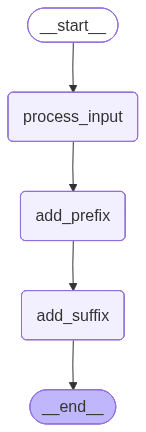

In [23]:
# Create the graph
graph = create_simple_graph()
graph

In [24]:
initial_state = {
        "input_text": "hello",
        "output_text": ""
    }

final_state = graph.invoke(initial_state)

final_state

Node 1 - Processing: 'hello' -> 'HELLO'
Node 2 - Adding prefix: 'HELLO' -> 'PROCESSED: HELLO'
Node 3 - Adding suffix: 'PROCESSED: HELLO' -> 'PROCESSED: HELLO [COMPLETE]'


{'input_text': 'Goodbye!', 'output_text': 'PROCESSED: HELLO [COMPLETE]'}

In [25]:
initial_state = {
        "input_text": "Hello Everyone, Thankyou so much for taking this course.",
        "output_text": ""
    }

final_state = graph.invoke(initial_state)

final_state

Node 1 - Processing: 'Hello Everyone, Thankyou so much for taking this course.' -> 'HELLO EVERYONE, THANKYOU SO MUCH FOR TAKING THIS COURSE.'
Node 2 - Adding prefix: 'HELLO EVERYONE, THANKYOU SO MUCH FOR TAKING THIS COURSE.' -> 'PROCESSED: HELLO EVERYONE, THANKYOU SO MUCH FOR TAKING THIS COURSE.'
Node 3 - Adding suffix: 'PROCESSED: HELLO EVERYONE, THANKYOU SO MUCH FOR TAKING THIS COURSE.' -> 'PROCESSED: HELLO EVERYONE, THANKYOU SO MUCH FOR TAKING THIS COURSE. [COMPLETE]'


{'input_text': 'Goodbye!',
 'output_text': 'PROCESSED: HELLO EVERYONE, THANKYOU SO MUCH FOR TAKING THIS COURSE. [COMPLETE]'}